## Are the data Non-stationary  ##
The time series data from data regions and even sub-domains is likely to be non-stationary with respect to each other i.e. it's mean and variance is different. In fact, the data may not be stationary with a single subdomain.

The diagnostic type runs i.e. instantaneous single time-step prediction is solved and can get really accurate results with simple neural networks and particularly good results with skip connections. 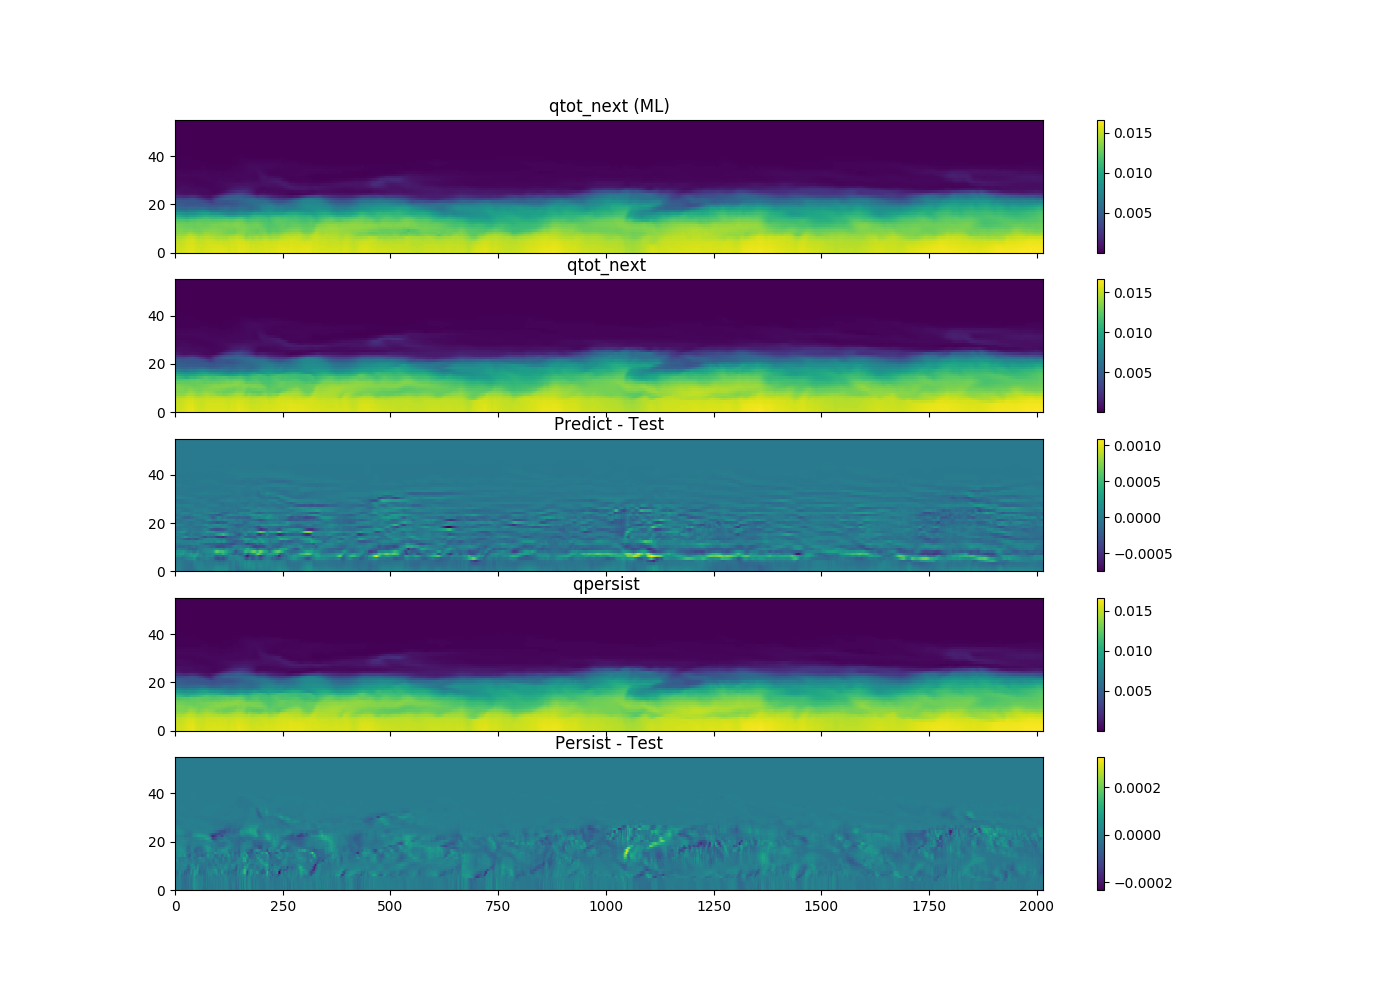

or with skip

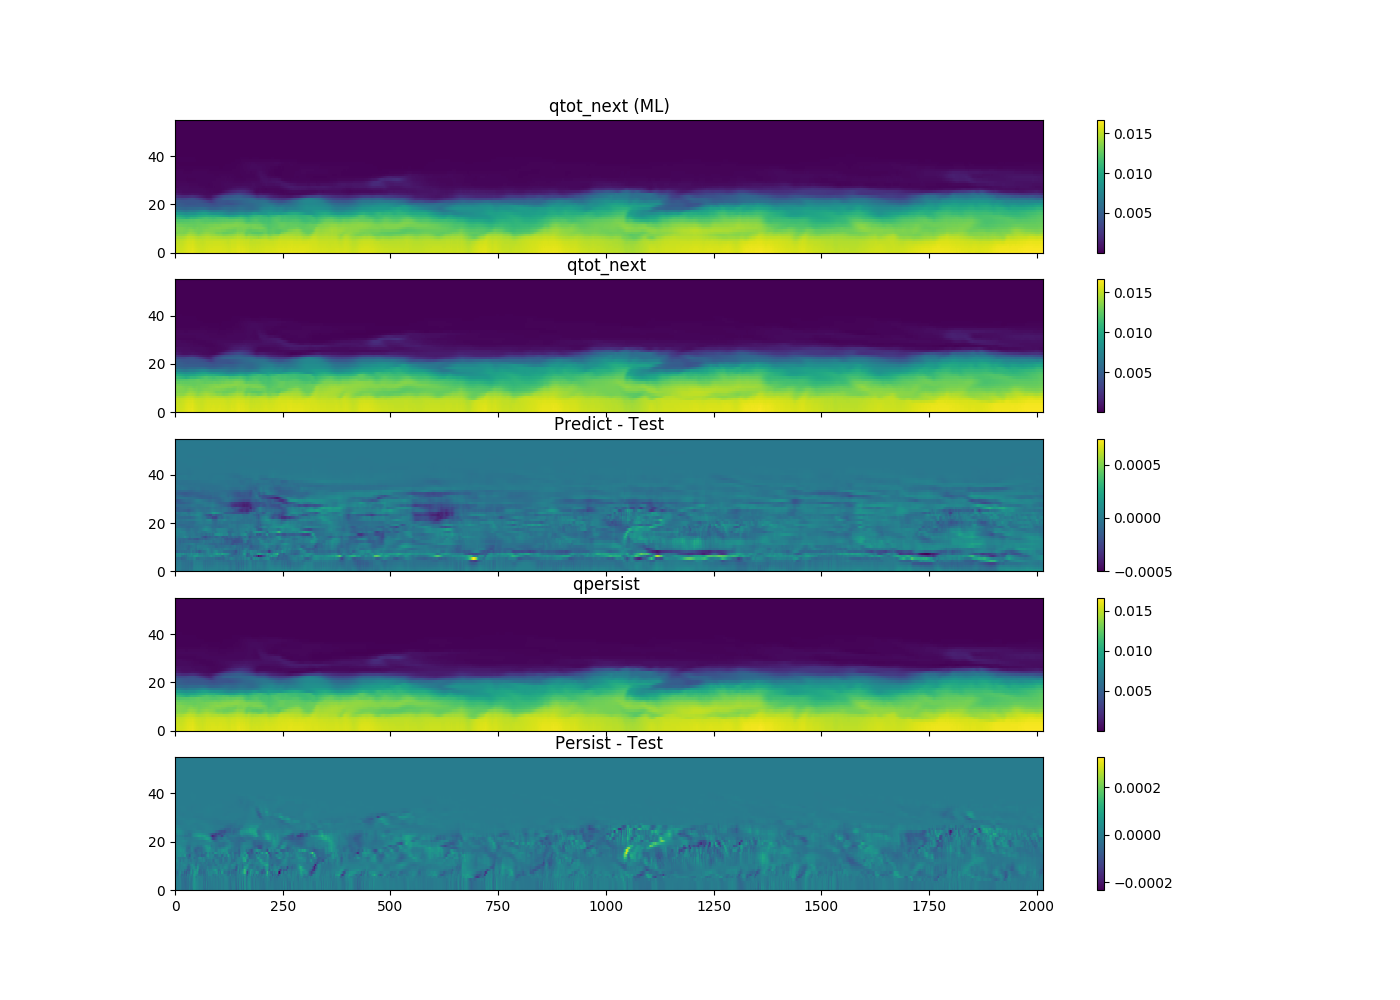

However, the same model in prognostic setup does poorly e.g. here with the skip connection:

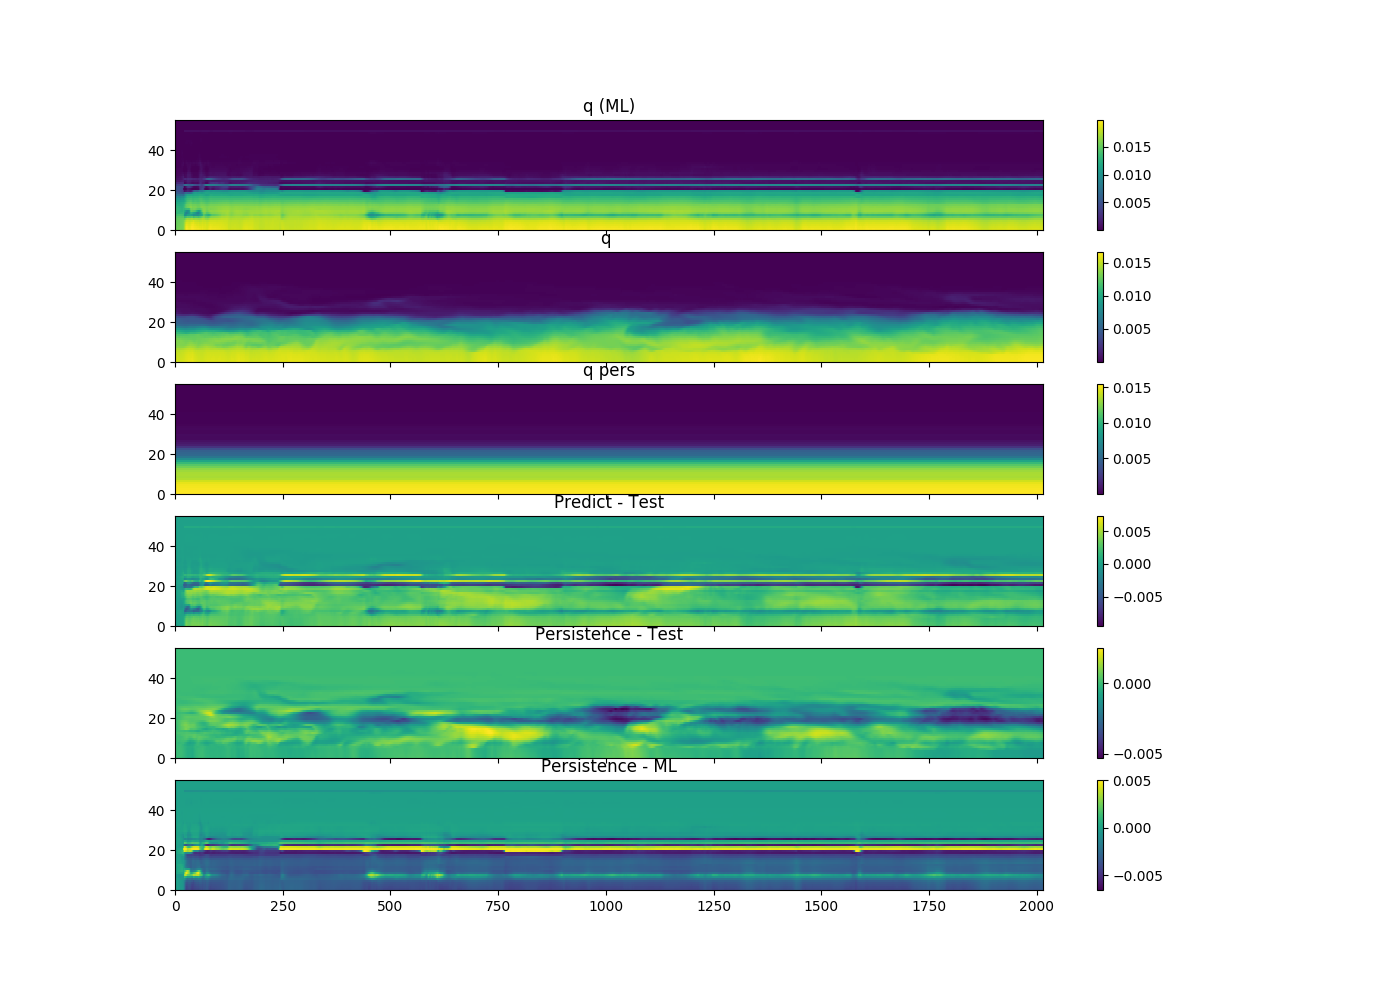

The way to make these prognostic runs more stable i.e. not have the model blowup really quickly is by having the data normalised to 0 -> 1 and then have final layer go through a sigmoid activation. This forces the model the behave better than when the data are standardised. It still does not stop the data from going a little off the rails relatively soon and then getting stuck in the particular data valley. This made me think if the issues is covariance shift in the data as you running the data in progonistic mode and the model response gets erratic because of that. In order to get around that I decided to try batch normalisation on the inputs so right after the inputs layer e.g. 

```
def forward(self, x):
        x = self.act(self.bn(self.fc1(x)))
        # x = self.act(self.fc1(x))
        for l in self.fcs:
            # x = self.act(self.bn(l(x)))
            x = self.act(l(x))
        x = self.sig(self.out(x))
        return x
```

This does make the dynamical run a lot more stable and better dynamical response, but the model appears to have a bias in it.

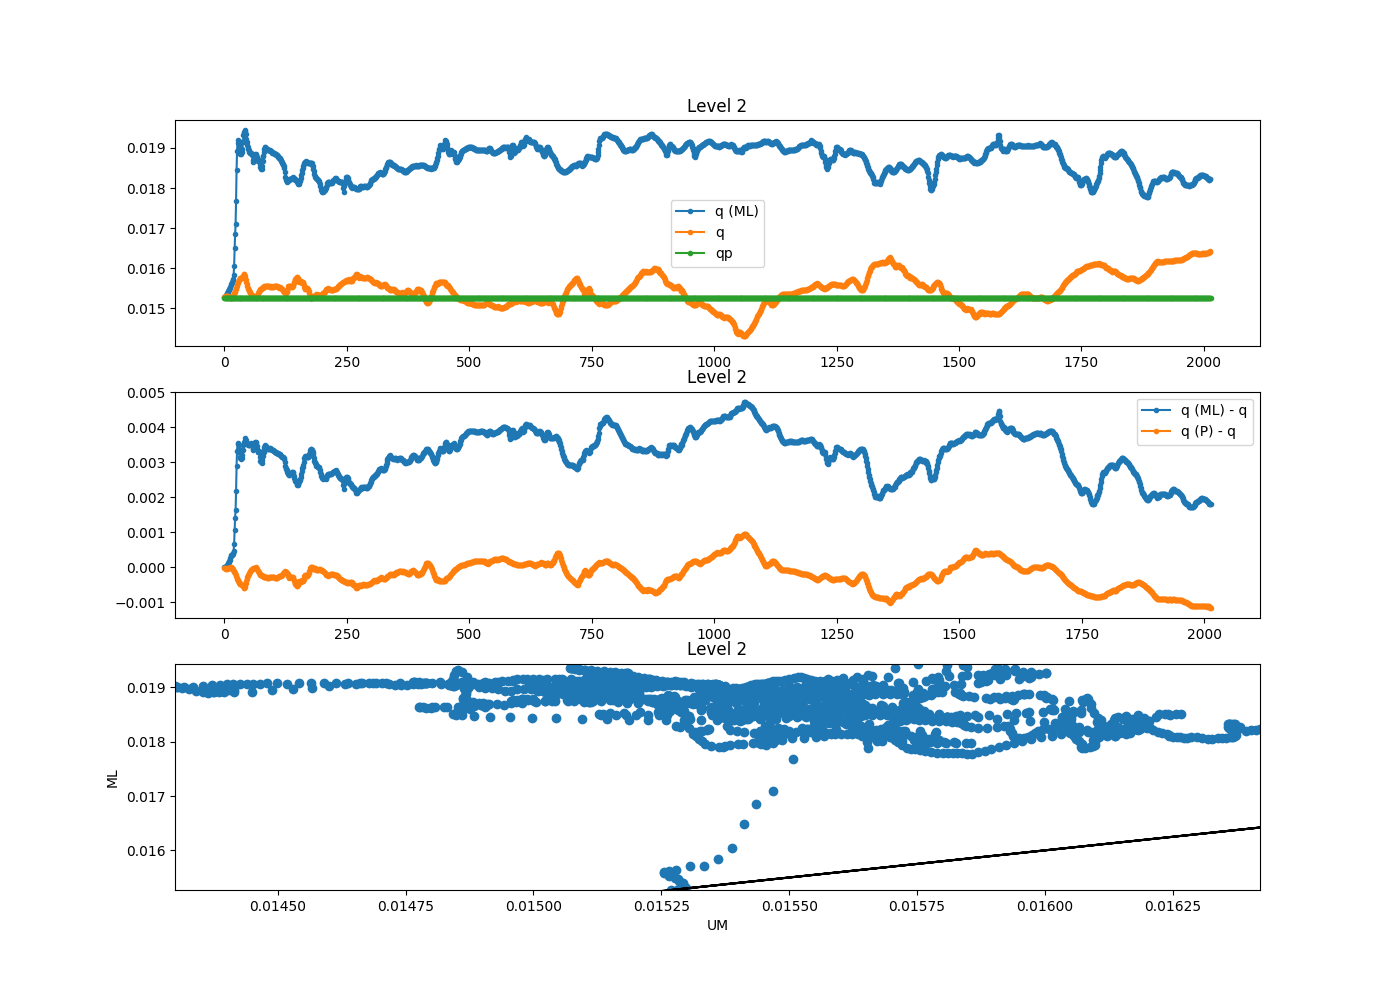

First of all, the maybe the reason batch normalisation works better is because data are non-stationary and batch norm is making it statinary as it is working on a particular batch and normalising across it. I am now wondering if the issue with this bias is the fact during training batch normalisation keeps a running_mean of statics (mean and variance) and at inference time this running mean is used. This running mean, a sort total data average could be introducing this bias in the data at inference time. It is therefore worth trying to do inference in such a way that it can learn the validation test mean and variance first and then use that for batch normalisation. Some options for doing that:

1. At inference time, run the model in train mode withouth any backprop to for some batches for batch norm layer to learn the new statistics and then switch to normal recursive run.

2. while training have the variables on the same order of magnitude and then use batch normalisation on to make the data stationary. At inference, same as 1, have the model spin-up to learn the stats of the region

3. Box-Cox transform the data, though batch normalisation is probably doing something like that one batch at a time. Should look at the data and make sure this is the case.


## What works and does not ##

    * Batch normalisation is problematic as its running mean and std are likely not applicable for the inference time. 
    * Skip connections with stacked data give really poor performance
    * Stacked data gives slightly better performance for prognostic runs when compared with shuffled data, but diagnostic runs suffer in performance. There is large drift early because of diagnostic initail run not being great. 
    * Teacher forcing mode gave really unstable results and no improvement in fits.
 
 A lot of the issues seen with stacked data (even wtih shuffled batches in data_io_batched.py) are likely to be due to drifiting mean and variance of data i.e. non-stationary. The only thing to explore now is try power-tranform and see what differnce that makes.

Tried skip connection such that:

```
    def forward(self, x):
        inputs = x[...,self.subskip_indx]
        x = self.act(self.fc1(x))
        for l in self.fcs:
            x = self.act(l(x))
        x = self.act(self.skip(x))
        # x[...,self.subskip_indx] = x[...,self.subskip_indx] + inputs
        x = self.sig(self.out(x)) + inputs
        return x

```

And the model learn nothing and recreates persistence. Well, what it learns is to set to sigmoid(out(x)) to zero. Perhaps  the learning rate is too high. Also, with sigmoid output added to inputs, you can only ever have positive increments, which is not correct. Change to Tanh to see if that improves the outputs.